# Experiment regarding the line finder framework

In [1]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
from src.data.dataset_line_finder import DatasetLineFinder

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
parameters = {"input_folder": '..\\data\\cBAD-ICDAR2019', "max_side": 1000}
ds = DatasetLineFinder(inf_type='train', parameters=parameters)

In [4]:
n = 2

In [5]:
img = ds[n]['image'].numpy().transpose(1,2,0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)


sp = ds[n]['label'][:, 0:2]
angles = ds[2]['label'][:, 2]
box_size = ds[n]['label'][:, 3]

#plt.imshow(img)

In [6]:
labels = np.zeros(img.shape)

for k, s in enumerate(sp):
    x = int(s[0].item())
    y = int(s[1].item())
    cv2.circle(labels, (x, y), box_size[0], (1.0,0,0), 4)
    cv2.line(labels, (x,y), (x + 2*box_size[0]*np.cos(angles[k]), y - 2*box_size[0]*np.sin(angles[k])), (0, 1.0, 0), 4)
    
    
#plt.imshow(labels)

Some plots that show what the dataset ouputs

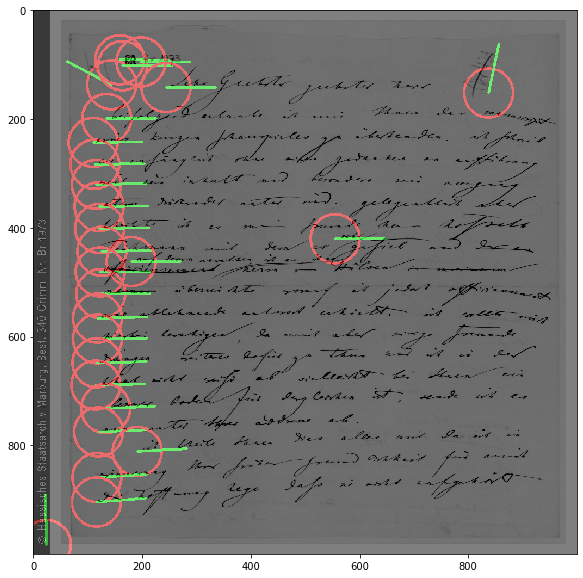

In [7]:
combined = cv2.addWeighted(img, 0.5, labels, 0.5, 0)

plt.figure(figsize=(20,10))
plt.imshow(combined)

In [4]:
def draw_start_points(image: torch.tensor, labels: torch.tensor):
    img = image.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    sp = labels[:, 0:2]
    angles = labels[:, 2]
    box_size = labels[:, 3]

    labels_img = np.zeros(img.shape)

    for k, s in enumerate(sp):
        x = int(s[0].item())
        y = int(s[1].item())
        cv2.circle(labels_img, (x, y), box_size[0], (1.0, 0, 0), 4)
        cv2.line(labels_img, (x, y),
                 (x + 2 * box_size[0] * np.cos(angles[k]), y - 2 * box_size[0] * np.sin(angles[k])),
                 (0, 1.0, 0), 4)

    comb = cv2.addWeighted(img, 0.5, labels_img, 0.5, 0)
    comb = torchvision.transforms.ToTensor()(comb).float()

    return comb

In [9]:
import torchvision

c = draw_start_points(ds[0]['image'], ds[0]['label'])
#plt.imshow(c.permute(1,2,0))

In [11]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')

import torch
import numpy as np
import torch.nn as nn
from src.model.line_finder import LineFinder
from src.data.dataset_line_finder import DatasetLineFinder

In [12]:
lf = LineFinder('cpu')

In [13]:
parameters = {"input_folder": '..\\data\\cBAD-ICDAR2019', "max_side": 1000}
ds = DatasetLineFinder(inf_type='train', parameters=parameters)

In [14]:
n = 0

image = ds[n]['image'].unsqueeze(0)
label = ds[n]['label'].unsqueeze(0)

In [15]:
out = lf(image)

In [21]:
from scipy.optimize import linear_sum_assignment

class LineFinderLoss(nn.Module):
    def __init__(self, alpha=0.01):
        super(LineFinderLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.alpha = alpha

    def forward(self, pred, label):
        batch_size = pred.shape[0]
        N = pred.shape[1]
        M = label.shape[1]

        loss = 0

        for b in range(batch_size):
            cost = torch.zeros(N, M)

            for n in range(N):
                for m in range(M):
                    cost[n, m] = self.mse(pred[b, n, 0:2], label[b, m, 0:2])

            
            inp_idx, target_idx = linear_sum_assignment(cost.detach())

        return cost

In [33]:
label

tensor([[[ 1.3908e+02,  8.7815e+01,  6.2364e-03,  5.5256e+01],
         [ 7.0019e+02,  1.1176e+02, -6.0558e-02,  5.5256e+01],
         [ 1.3908e+02,  1.2437e+02,  8.2606e-02,  5.5256e+01],
         [ 1.3426e+02,  1.4118e+02,  5.4093e-02,  5.5256e+01],
         [ 2.6420e+02,  1.5168e+02, -1.6418e-02,  5.5256e+01],
         [ 1.4485e+02,  1.8277e+02, -1.0673e-02,  5.5256e+01],
         [ 1.7372e+02,  2.5588e+02, -6.6311e-03,  5.5256e+01],
         [ 1.7806e+02,  3.0798e+02, -2.9497e-03,  5.5256e+01],
         [ 1.7469e+02,  3.6429e+02, -6.6186e-03,  5.5256e+01],
         [ 1.6891e+02,  4.1765e+02, -3.8731e-03,  5.5256e+01],
         [ 1.6891e+02,  4.6639e+02, -1.1017e-02,  5.5256e+01],
         [ 1.6891e+02,  5.2269e+02, -9.0820e-03,  5.5256e+01],
         [ 1.6651e+02,  5.7605e+02, -1.2172e-02,  5.5256e+01],
         [ 1.6747e+02,  6.2479e+02, -9.9214e-03,  5.5256e+01],
         [ 1.6747e+02,  6.7605e+02, -6.0255e-03,  5.5256e+01],
         [ 1.6987e+02,  7.2941e+02, -8.0735e-03,  5.525

In [35]:
label[0,np.array([1,3,5]),:]

tensor([[ 7.0019e+02,  1.1176e+02, -6.0558e-02,  5.5256e+01],
        [ 1.3426e+02,  1.4118e+02,  5.4093e-02,  5.5256e+01],
        [ 1.4485e+02,  1.8277e+02, -1.0673e-02,  5.5256e+01]])

In [22]:
lossf = LineFinderLoss()

In [23]:
#out.shape

In [24]:
#label.shape

In [25]:
c = lossf(out, label)

torch.Size([1024, 21])


In [44]:
b = c.detach().numpy()

In [ ]:
c = cost_out.detach().numpy()

In [16]:
del c

In [19]:
c = lout.detach().numpy()

In [20]:
linear_sum_assignment(c)

(array([ 30, 103, 104, 105, 107, 108, 111, 112, 113, 114, 116, 117, 120,
        122, 124, 130, 132, 134, 141, 150, 163, 174, 194, 217, 228, 556,
        836], dtype=int64),
 array([26,  7,  8,  9, 10, 11, 15, 16, 17, 18, 19, 20, 22, 24, 25,  1,  0,
         6, 13, 21,  2, 14,  3, 23,  5, 12,  4], dtype=int64))

In [26]:
x = torch.tensor(3.2)

In [27]:
x.detach().numpy()

array(3.2, dtype=float32)

In [29]:
x

tensor(3.2000)

In [ ]:

            print('3')
            cost = cost.detach().numpy()
            inp_idx, target_idx = linear_sum_assignment(cost)
            print('2')
            X = torch.zeros(N, M)
            for p_idx in inp_idx:
                for l_idx in target_idx:
                    X[p_idx, l_idx] = 1
            print('3')
            # Loss = Sum_{n=0}^N Sum_{m=0}^M    X_nm [alpha*MSE(l_n, p_m) - Log(c_m)] - (1- X_nm) Log(1-c_m)
            # where:
            #   N:      prediction dimension
            #   M:      label dimension
            #   X_mn:   linear assignement matrix
            #   l_n:    label coordinates
            #   p_m:    prediction coordinates
            #   c_m:    confidence scores
            for n in range(N):
                for m in range(M):
                    loss += X[n, m]*(self.alpha*self.mse(inp[n, 0:2], target[m, 0:2]) - torch.log(inp[n, 4]))\
                            - (1-X[n, m])*(torch.log(1-inp[n, 4]))
            #loss += nn.MSELoss()(input[:, 3], target[:, 3])
        
        return loss